# Import Libraries

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 5.0)
from hmmlearn import hmm
import seaborn as sns

# Example 
The elusive leader of a dangerous criminal organization is known to travel between Los Angeles and New York The FBI has no clue about  his whereabouts at the initial time The FBI has no clue about the probability that he would stay or move to the other city at each time period At each time period the FBI could get sighting reports (or evidence of his presence in a city), including a non-sighting null report.

In [2]:
# Define the observation sequence
string_labels = ['null', 'LA', 'LA', 'null', 'NY', 'null', 'NY', 'NY', 'NY', 'null',
                'NY', 'NY', 'NY', 'NY', 'NY', 'null', 'null', 'LA', 'LA', 'NY']
mapping = {'LA': 0, 'NY': 1, 'null': 2}
observations = [mapping[obs] for obs in string_labels]
observations = np.array(observations)# Initial transition matrix
# Define the initial parameters
start_probabilities = np.array([0.5, 0.5])
transition_matrix = np.array([[0.5, 0.5], [0.5, 0.5]])
emission_matrix = np.array([[0.4, 0.1, 0.5], [0.1, 0.5, 0.4]])

# forward/backward Algorithms

In [3]:
def forward(observations, transition_matrix, emission_matrix, initial_distribution):
    num_states = transition_matrix.shape[0]
    num_observations = len(observations)
    # Initialize the alpha matrix
    alpha = np.zeros((num_observations, num_states))
    alpha[0, :] = initial_distribution * emission_matrix[:, observations[0]]
    # Forward algorithm iteration
    for t in range(1, num_observations):
        for j in range(num_states):
            alpha[t, j] = np.dot(alpha[t - 1], transition_matrix[:, j]) * emission_matrix[j, observations[t]]
    return alpha

def backward(observations, transition_matrix, emission_matrix):
    num_states = transition_matrix.shape[0]
    num_observations = len(observations)
    # Initialize the beta matrix
    beta = np.zeros((num_observations, num_states))
    beta[num_observations - 1] = np.ones((num_states))
    # Backward algorithm iteration
    for t in range(num_observations - 2, -1, -1):
        for j in range(num_states):
            beta[t, j] = np.dot(beta[t + 1] * emission_matrix[:, observations[t + 1]], transition_matrix[j, :])
    return beta

# Baum-Welch ahgorithm

In [4]:
def baum_welch(V, a, b, initial_distribution, n_iter=20):
    M = a.shape[0]
    T = len(V)
    pai = initial_distribution.copy()  # Copy initial distribution for updates
    log_likelihoods = []

    for n in range(n_iter):
        alpha = forward(V, a, b, pai)
        beta = backward(V, a, b)

        xi = np.zeros((M, M, T - 1))
        for t in range(T - 1):
            
            # E-step: Compute xi
            denominator = np.dot(np.dot(alpha[t, :].T, a) * b[:, V[t + 1]].T, beta[t + 1, :])
            for i in range(M):
                numerator = alpha[t, i] * a[i, :] * b[:, V[t + 1]].T * beta[t + 1, :].T
                xi[i, :, t] = numerator / denominator
        
        gamma = np.sum(xi, axis=1)
        a_new = np.sum(xi, axis=2) / np.sum(gamma, axis=1).reshape((-1, 1))

        # M-step: Update transition matrix 'a'
        a = a_new
        
        # Update initial distribution 'pai'
        pai = gamma[:, 0]  
        
        # Update gamma to include T'th element
        gamma = np.hstack((gamma, np.sum(xi[:, :, T - 2], axis=0).reshape((-1, 1))))
        
        K = b.shape[1]
        denominator = np.sum(gamma, axis=1)
        
        for l in range(K):
            # Update emission matrix 'b'
            b[:, l] = np.sum(gamma[:, V == l], axis=1)
        
        b = np.divide(b, denominator.reshape((-1, 1)))  # Normalize 'b'

        # Compute likelihood using the forward algorithm
        log_likelihood = np.log(np.sum(alpha[-1]))  # Log of sum of alpha at final time step
        log_likelihoods.append(log_likelihood)

    return a, b, pai, log_likelihoods

In [5]:
A,B,pai,log_likelihoods = baum_welch(observations, transition_matrix, emission_matrix, start_probabilities)

In [6]:
print("\ntrainsition matrix A:")
print(A)
print("\nEmission matrix B:")
print(B)
print("\nintial Probabilities (pai):")
print(pai)
print("\nlog-likelihood:")
print(log_likelihoods[-1])


trainsition matrix A:
[[0.69092982 0.30907018]
 [0.09339999 0.90660001]]

Emission matrix B:
[[0.58070809 0.00100364 0.41828826]
 [0.         0.76214119 0.23785881]]

intial Probabilities (pai):
[1. 0.]

log-likelihood:
-17.635926028015597


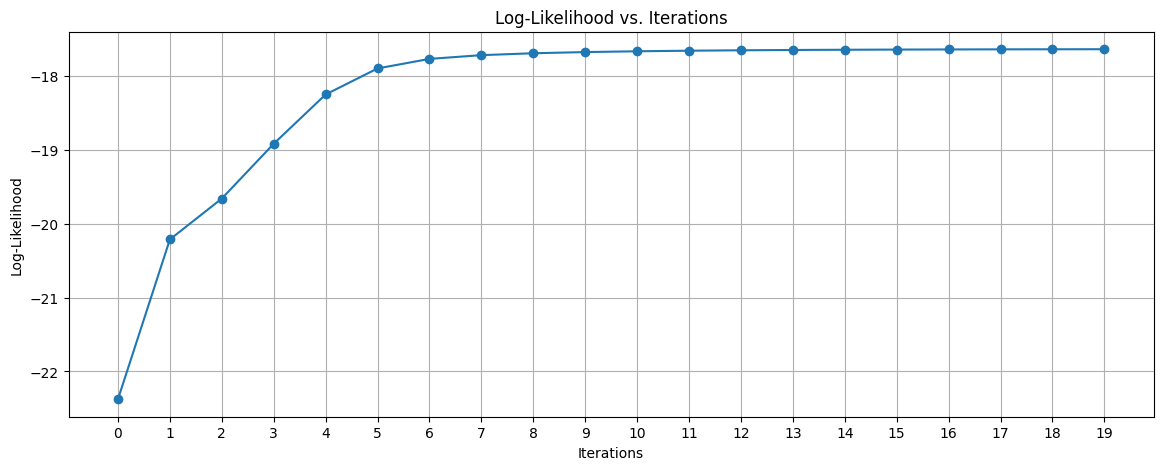

In [7]:
# Assuming you have 'log_likelihoods' variable containing log-likelihood values
iterations = range(0,20)
plt.plot(iterations, log_likelihoods, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs. Iterations')
plt.grid(True)
plt.xticks(range(0, 20, 1))
plt.show()

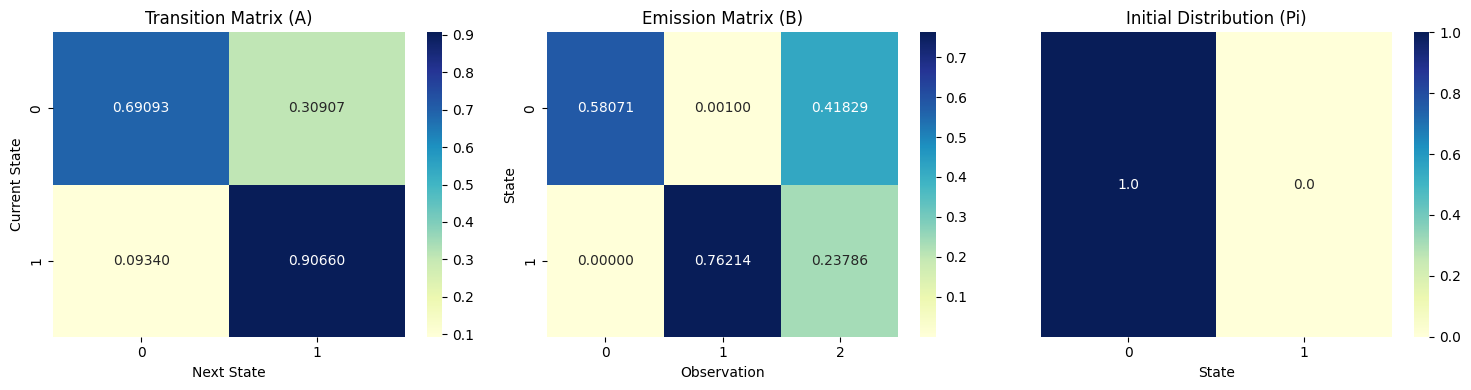

In [8]:
# Create subplots for transition matrix (a), emission matrix (b), and initial distribution (pai)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plotting transition matrix (a)
sns.heatmap(A, annot=True, cmap='YlGnBu', fmt=".5f", ax=axs[0])
axs[0].set_title('Transition Matrix (A)')
axs[0].set_xlabel('Next State')
axs[0].set_ylabel('Current State')

# Plotting emission matrix (b)
sns.heatmap(B, annot=True, cmap='YlGnBu', fmt=".5f", ax=axs[1])
axs[1].set_title('Emission Matrix (B)')
axs[1].set_xlabel('Observation')
axs[1].set_ylabel('State')

# Plotting initial distribution (pai)
sns.heatmap(pai.reshape(1, -1), annot=True, cmap='YlGnBu', fmt=".1f", ax=axs[2])
axs[2].set_title('Initial Distribution (Pi)')
axs[2].set_xlabel('State')
axs[2].set_yticks([])  # No y-axis labels for initial distribution
plt.tight_layout()
plt.show()

# compare results with hmmlearn

In [9]:
# Define the observation sequence
observations = ['null', 'LA', 'LA', 'null', 'NY', 'null', 'NY', 'NY', 'NY', 'null',
                'NY', 'NY', 'NY', 'NY', 'NY', 'null', 'null', 'LA', 'LA', 'NY']
mapping = {'LA': 0, 'NY': 1, 'null': 2}
observations = [mapping[obs] for obs in observations]
observations = np.array(observations)# Initial transition matrix
# Define the initial parameters
start_probabilities = np.array([0.5, 0.5])
transition_matrix = np.array([[0.5, 0.5], [0.5, 0.5]])
emission_matrix = np.array([[0.4, 0.1, 0.5], [0.1, 0.5, 0.4]])

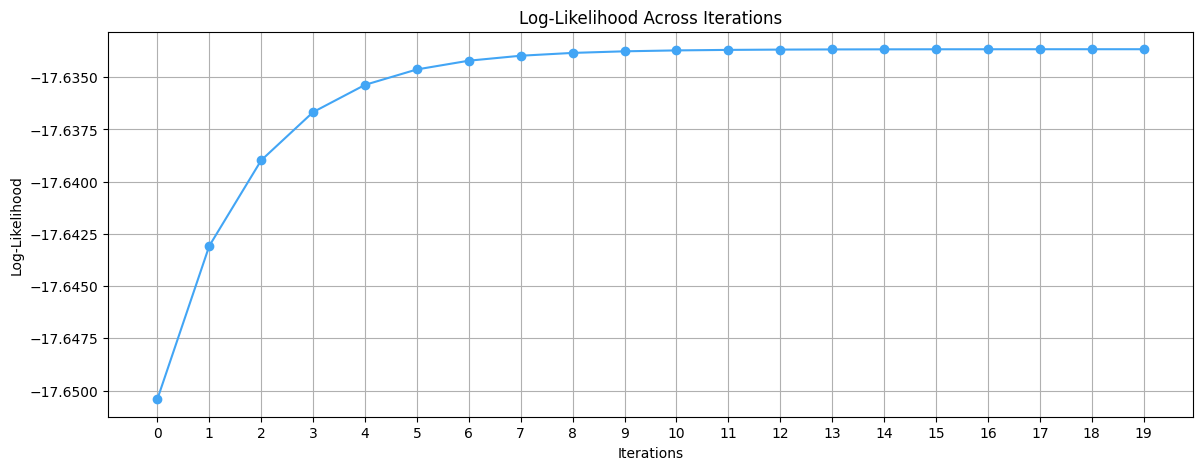

In [10]:
# Create an HMM model
model = hmm.CategoricalHMM(n_components=2, n_iter=20, init_params='')

# Assuming you have defined 'start_probabilities', 'transition_matrix', 'emission_matrix', and 'observations'
# Set initial parameters directly into the model attributes
model.startprob_ = start_probabilities
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# Train the modelzz
hmm_likelihoods = []  # To store log-likelihood values across iterations
for i in range(model.n_iter):
    model.fit(observations.reshape(-1, 1))
    hmm_likelihoods.append(model.score(observations.reshape(-1, 1)))

# Plot log-likelihoods to visualize convergence
plt.plot(hmm_likelihoods, marker='o', color='#42A5F5')
plt.title('Log-Likelihood Across Iterations')
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.xticks(range(0, 20, 1))
plt.show()

In [11]:
hmm_transmat = model.transmat_
print("\nhmmlearn trainsition matrix A:")
print(hmm_transmat)
hmm_emission_probs = model.emissionprob_
print("\nhmmlearn Emission matrix B:")
print(hmm_emission_probs)
hmm_startprob = model.startprob_
print("\nhmmlearn intial Probabilities (pai):")
print(hmm_startprob)
hmm_log = model.score(observations.reshape(-1, 1))
print("\nhmmlearn log-likelihood:")
print(hmm_log)


hmmlearn trainsition matrix A:
[[0.69011918 0.30988082]
 [0.09332134 0.90667866]]

hmmlearn Emission matrix B:
[[0.58158946 0.00000021 0.41841033]
 [0.         0.76206164 0.23793836]]

hmmlearn intial Probabilities (pai):
[1. 0.]

hmmlearn log-likelihood:
-17.633659779516037


# decoding

In [12]:
def viterbi(obs, A, B, pai):
    num_states = A.shape[0]
    T = len(obs)

    # Initialization
    V = np.zeros((T, num_states))
    path = np.zeros((num_states, T))

    V[0] = pai * B[:, obs[0]]

    # Viterbi algorithm
    for t in range(1, T):
        for j in range(num_states):
            probabilities = V[t - 1] * A[:, j] * B[j, obs[t]]
            path[j, t] = np.argmax(probabilities)
            V[t, j] = np.max(probabilities)

    # Backtracking to find the most probable path
    best_path = [int(np.argmax(V[T - 1]))]
    for t in range(T - 2, -1, -1):
        best_path.append(int(path[best_path[-1], t + 1]))
    best_path = best_path[::-1]

    return best_path

In [13]:
sequence = viterbi(observations,A,B,pai)
print("Most probable sequence of hidden states:", sequence)

Most probable sequence of hidden states: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1]


In [14]:
logprob, sequence = model.decode(observations.reshape(-1, 1))
print("hmmlearn Most probable sequence of hidden states:", sequence)

hmmlearn Most probable sequence of hidden states: [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1]


# differnce between liklihood if we use different seeds

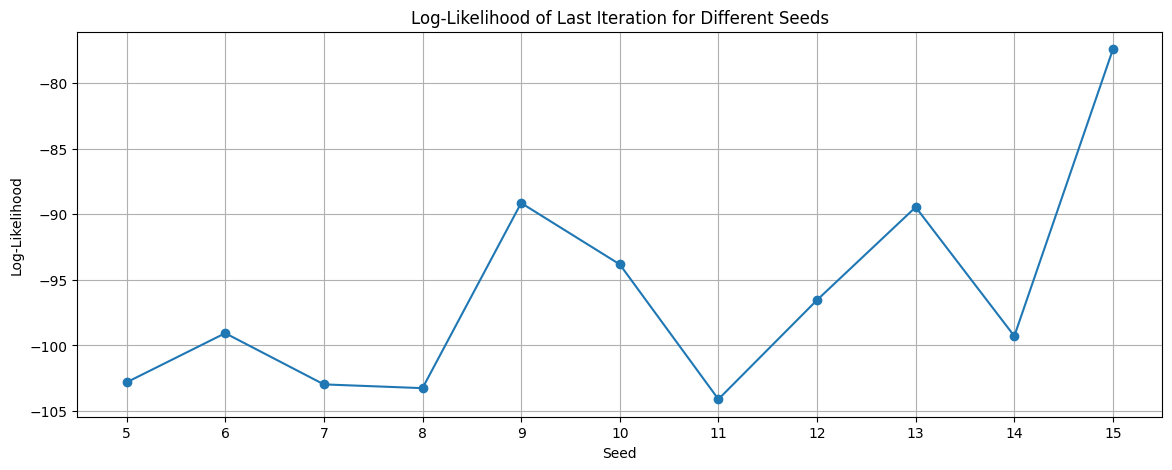

In [15]:
# Function to create and train a CategoricalHMM with a given random seed
def train_categorical_hmm_with_seed(seed,o):
    np.random.seed(seed)
    model = hmm.CategoricalHMM(n_components=2,n_iter=20)
    o = o.reshape(-1, 1)
    model.fit(o)
    return model

num_seeds = 10
seed_values = range(5,16)  # Different seeds
hmm_models = [train_categorical_hmm_with_seed(seed,observations) for seed in seed_values]

# Store log-likelihoods of the last iteration for each model
log_likelihoods = []
for model in hmm_models:
    log_likelihoods.append(model.score(model.sample(100)[0]))

# Plot log-likelihoods for each seed
plt.plot(seed_values, log_likelihoods, marker='o')
plt.xlabel('Seed')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood of Last Iteration for Different Seeds')
plt.grid(True)
plt.xticks(range(5,16))
plt.show()